In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unet import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, MultiDecoderUNet
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from tqdm.notebook import tqdm
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
import glob
import two_channel_dataset_DIP_another
from torch.nn import init
from torch.autograd import Variable
# packing loading

file1000591.h5_Layer16.npz


In [2]:
#test image loading
for test_direct,test_target,test_smap,test_mask,mask_2,A_I,test_kspace in two_channel_dataset_DIP_another.test_loader:
    k_np =test_kspace
    A_k_ref = k_np[:,:, 0, :, :] + 1j * k_np[:,:, 1, :, :]
    sense_maps_ref = test_smap[:,:, 0, :, :] + 1j *test_smap[:,:, 1, :, :]
    mask_from_file = test_mask[0]

# neighbor image loading
neighbors=[]   
mps_list =[]
mask_list =[]
for direct,  target,    smap,   mask,   mask_in,A_I_test,t_kspace in two_channel_dataset_DIP_another.train_loader:
    mask_from_file = mask_in[0]
    k_np_neigh =t_kspace.float()
    sense_map_neighbor = smap[:,:, 0, :, :] + 1j *smap[:,:, 1, :, :]
    A_k_neighbor = k_np_neigh[:, :,0, :, :] + 1j * k_np_neigh[:, :,1, :, :]
    neighbors.append( A_k_neighbor[0])
    mask_list.append(mask_from_file)
    mps_list.append(sense_map_neighbor[0])

In [3]:
print(len(neighbors))

5


In [4]:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)
# network initalization

In [5]:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img)))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp)))

def ksp_and_mps_to_gt(ksp, mps):
    gt = mps.conj() * ifft_with_shifts(ksp)
    #print(gt.shape)
    gt = torch.sum(gt, axis=0)
    return gt

def ksp_and_mps_to_gt_combine(ksp, mps):
    gt = mps.conj() * ifft_with_shifts(ksp)
    #print(gt.shape)
    gt = torch.sum(gt, axis=1)
    return gt

def mps_and_gt_to_ksp(mps, gt):
    ksp = fft_with_shifts(mps * gt)
    return ksp

# fft and ifft function

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
net =  MultiDecoderUNet(n_channels=2, n_classes=2, num_decoders=5, bilinear=True).to(device)
init_weights(net, init_type='normal',init_gain=0.02)
num_epochs = 500
learning_rate = 3e-4
show_every = 50
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
# parameter

initialize network with normal


In [8]:
ksp1 = A_k_ref[0]
mps1 = sense_maps_ref[0]

In [9]:
mps_combine = torch.stack(mps_list, dim=0)
mask_combine = torch.stack(mask_list, dim=0)
kspace_combine = torch.stack(neighbors, dim=0)

In [10]:
# print(ksp1.shape)
# print(kspace_combine.shape)
# print(mask_combine.shape)
# print(mps_combine.shape)

In [11]:
new_ref = ksp_and_mps_to_gt(mask_from_file * ksp1, mps1) # one image

In [12]:
new_ref_combine = ksp_and_mps_to_gt_combine(mask_combine * kspace_combine , mps_combine ) # combine image

In [13]:
new_ref_combine_expanded = new_ref_combine.unsqueeze(1) # To make the image shape fit into the kspace changed back

In [14]:
back_ksp = mps_and_gt_to_ksp(mps1,new_ref )

In [15]:
back_ksp_combine = mps_and_gt_to_ksp(mps_combine,new_ref_combine_expanded )

In [16]:
number = len(neighbors)

In [18]:
ref = torch.zeros(5,2,320,320)
ref[:,0,:,:] = new_ref_combine.real
ref[:,1,:,:] = new_ref_combine.imag

In [19]:
with torch.no_grad():
    netoutput_combine = torch.stack([out[0] for out in net(ref.to(device))], dim=0)
    print(netoutput_combine.shape)
    scale_factor = torch.linalg.norm(netoutput_combine)/torch.linalg.norm(new_ref_combine.to(device))
    target_ksp_combine = scale_factor * kspace_combine.to(device)
    #print('K-space scaled by: ', scale_factor)

torch.Size([5, 2, 320, 320])


In [20]:
print(target_ksp_combine.shape)

torch.Size([5, 15, 320, 320])


In [21]:
gt1_combine =  ksp_and_mps_to_gt_combine( kspace_combine , mps_combine )

In [22]:
print(gt1_combine.shape)

torch.Size([5, 320, 320])


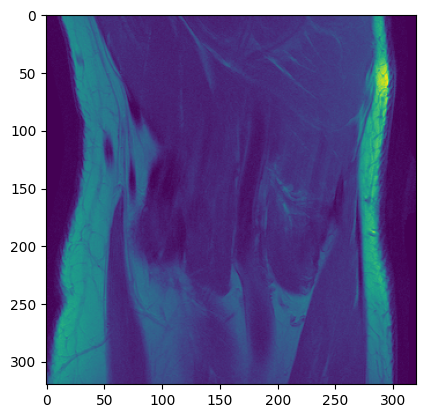

In [23]:
plt.imshow(gt1_combine[1].abs())

In [24]:
gt1_combine = torch.abs(gt1_combine)/torch.max(torch.abs(gt1_combine))

In [25]:
print(mps_combine.shape)
img_map = torch.sum(torch.abs(mps_combine), axis=1) > 0
print(img_map.shape)

torch.Size([5, 15, 320, 320])
torch.Size([5, 320, 320])


In [26]:
losses = []
psnrs = []
avg_psnrs = []
exp_weight = .99
out_avg = torch.zeros_like(torch.abs(gt1_combine)).to(device)

In [27]:
#ref = ref.to(device)
mps1 = mps1.to(device)
ksp1 = ksp1.to(device)
mps_combine = mps_combine.to(device)
kspace_combine = kspace_combine.to(device)
mask_combine  = mask_combine.to(device)

In [28]:

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
#     for out in net(ref.to(device)):
#         final = torch.view_as_complex(out[0].permute(1, 2, 0).contiguous())
#     print(final.shape)
 
    net_output_combine = torch.stack([
        torch.view_as_complex(out[0].permute(1,2,0).contiguous()) for out in net(ref.to(device))
    ], dim=0)
    
    # stack network output together
    
    net_output_expand = net_output_combine.unsqueeze(1)
    pred_ksp_combine = mps_and_gt_to_ksp(mps_combine.to(device),net_output_expand)
    # new kspace updated
    
    new_pred_ksp = (1 - mask_combine).to(device) * pred_ksp_combine.detach() / scale_factor + mask_combine * kspace_combine

    new_ref = ksp_and_mps_to_gt_combine(new_pred_ksp, mps_combine)
    #random_smoothing_temp = torch.zeros(img_map.shape, dtype=torch.complex64, device=device)
    random_smoothing_temp = torch.zeros_like(new_ref).to(device)



    random_smoothing = new_ref + 1e-5 * torch.rand((number, 320, 320), dtype=torch.complex64).to(device)
    random_smoothing_temp += random_smoothing

    random_smoothing_final = random_smoothing_temp 
    ref[:, 0, :, :] = random_smoothing_final.real
    ref[:, 1, :, :] = random_smoothing_final.imag
    #print(ref.shape)
    # Continue with your loss computation and optimization steps
    loss = torch.linalg.norm(mask_combine * target_ksp_combine - mask_combine * pred_ksp_combine)
    #+ 0.01 * torch.linalg.norm(ref.to(device) - net_output_combine)
    #print(net_output_combine.requires_grad)  # Should be True
    #print(ref.requires_grad)                # Depends on your use-case; often False if it's a constant.
    loss.backward()
    optimizer.step()
#     with torch.no_grad():
#         out = img_map.to(device) * torch.abs(net_output)
#         out /= torch.max(out)
#         out = out.detach().squeeze()

#         losses.append(loss.item())

#         out_avg = out_avg * exp_weight + out * (1 - exp_weight)
#         avg_psnr = compute_psnr(np.array(torch.abs(gt1))/np.max(np.array(torch.abs(gt1))), np.array(out_avg.cpu())/float(out_avg.max().item()))
#         avg_psnrs.append(avg_psnr)

#         if epoch%show_every == 0:
#             plt.figure(figsize=(12,12))

#             plt.subplot(131)
#             plt.imshow(out_avg.cpu())
#             plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))

#             plt.subplot(132)
#             plt.imshow(np.abs(gt1.numpy()))
#             plt.title('Ground Truth')
#             #plt.colorbar()

#             plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [29]:
out = torch.abs(net_output_combine[1])

In [30]:
print(out.shape)

torch.Size([320, 320])


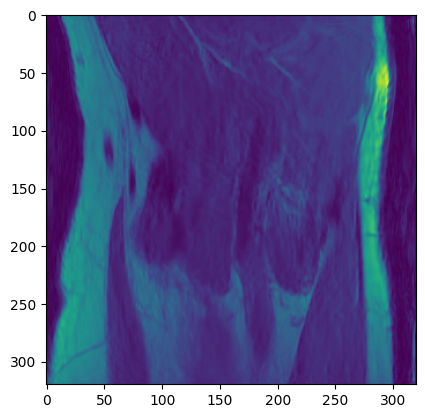

In [31]:
plt.imshow(out.cpu().detach().numpy())

In [32]:
import torch

# Save the encoder weights
torch.save(net.encoder.state_dict(), 'encoder_weights_new.pth')
